In [2]:
# just here
%load_ext autoreload
%autoreload 2

In [3]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import iblphotometry.io as ffio

In [22]:
# ONE instantiation
from one.api import ONE

one = ONE(base_url='https://alyx.internationalbrainlab.org', mode='remote')

# an example eid from alejandros dataset
eids = one.search(dataset='photometry.signal.pqt', lab='cortexlab')
eid = eids[26]

#

In [ ]:
# loading data
raw_photometry_df = one.load_dataset(eid, dataset='photometry.signal')
locations_df = one.load_dataset(eid, dataset='photometryROI.locations')
trials = one.load_dataset(eid, '*trials.table')
raw_dfs = ffio.from_dataframes(raw_photometry_df, locations_df)
raw_dfs

In [ ]:
# %%
# KCENIA / isosbestic specific
from one.api import ONE

one = ONE(cache_dir='/mnt/h0/kb/data/one')
data_loader = loaders.KceniaLoader(one, verbose=True)
df = pd.read_csv('/home/georg/code/ibl-photometry/src/local/website.csv')
eids = list(df['eid'])

raw_dfs = data_loader.load_photometry_data(eids[0])


In [31]:
trials

,intervals_0,intervals_1,goCue_times,response_times,choice,stimOn_times,contrastLeft,contrastRight,feedback_times,feedbackType,rewardVolume,probabilityLeft,firstMovement_times
0,336.2580,344.912302,342.1655,342.3122,-1,NaN,1.0,NaN,342.3126,-1,0.0,0.5,342.142571
1,344.9815,351.972502,345.6175,349.4200,-1,345.6171,1.0,NaN,349.4204,-1,0.0,0.5,349.254571
2,352.0047,361.072802,352.4799,358.5122,-1,352.4795,1.0,NaN,358.5126,-1,0.0,0.5,358.145571
3,361.1070,375.322402,362.6443,372.7733,-1,362.6439,1.0,NaN,372.7737,-1,0.0,0.5,368.030571
4,375.3645,384.112002,375.8813,381.5560,-1,375.8809,1.0,NaN,381.5564,-1,0.0,0.5,380.960571
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2739.1365,2759.594002,2739.8028,2757.0250,1,2739.8024,NaN,0.5,2757.0254,-1,0.0,0.5,2756.606571
176,2759.6563,2813.842102,2760.1854,2812.2935,1,2760.1850,0.5,NaN,2812.2936,1,3.0,0.5,2796.438571
177,2813.9142,2836.631002,2816.5519,2835.0659,1,2816.5515,1.0,NaN,2835.0660,1,3.0,0.5,2824.281571
178,2836.6774,2843.883602,2837.4179,2841.3183,-1,2837.4175,0.5,NaN,2841.3187,-1,0.0,0.5,2840.504571


from this data representation, running an processing pipeline is simple 

In [32]:
from iblphotometry import pipelines

# a single band pipelines
pipeline = pipelines.sliding_mad_pipeline

# getting the data for the GCaMP channel
raw_df = raw_dfs['GCaMP']

# restricting the photometry data to the time of the task +- 10 seconds
t_start = trials['intervals_0'].iloc[0] - 10
t_stop = trials['intervals_1'].iloc[-1] + 10
raw_df = raw_df.loc[t_start:t_stop]

df_processed = pipelines.run_pipeline(pipeline, raw_df)
df_processed

,SI,PPT
326.280652,0.345371,1.718132
326.313995,0.688156,1.748219
326.347307,0.816332,1.120588
326.380650,0.454725,1.762858
326.413994,1.019088,1.167394
...,...,...
2918.846743,-0.811561,-0.689368
2918.880087,0.517880,-0.331999
2918.913430,-0.128376,0.336124
2918.946741,-3.064226,0.786719


Pipelines are lists of tuples, where each tuple defines a `callable` pipeline function and a `dict` of its arguments. Each function is executed one after another, and the output of a function is fed into the next. This makes pipelines very modular they can be constructed with a lot of flexibility:

In [33]:
from iblphotometry import processing as fpp

pipeline = (
    (fpp.remove_spikes, dict(sd=5)),
    (
        fpp.lowpass_bleachcorrect,
        dict(),
    ),  # if an empty dict is passed, the default values will be used
    # (fpp.sliding_dFF, dict(w_len=10)),
    (fpp.zscore, dict(mode='median')),
)

df_processed = pipelines.run_pipeline(pipeline, raw_df)
df_processed

,SI,PPT
326.280652,0.423091,2.972447
326.313995,0.842051,3.023712
326.347307,0.998616,1.933368
326.380650,0.556590,3.047135
326.413994,1.246152,2.013288
...,...,...
2918.846743,-0.854700,-0.583010
2918.880087,0.545802,-0.280588
2918.913430,-0.134998,0.284811
2918.946741,-3.227773,0.666126


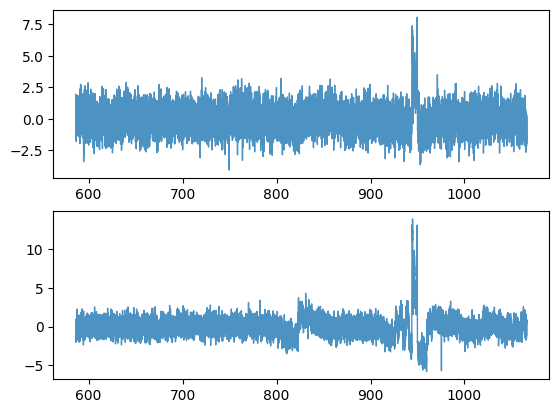

In [49]:
t_start = trials['intervals_0'].iloc[0] + 250
t_stop = t_start + 480
cols = df_processed.columns
fig, axes = plt.subplots(nrows=len(cols))
for i, col in enumerate(cols):
    axes[i].plot(df_processed[col].loc[t_start:t_stop], label=col, alpha=0.8, lw=1)

In [ ]:
t_start, t_stop
df_processed.loc[t_start:]

,SI,PPT
326.280652,0.423091,2.972447
326.313995,0.842051,3.023712
326.347307,0.998616,1.933368
326.380650,0.556590,3.047135
326.413994,1.246152,2.013288
...,...,...
2918.846743,-0.854700,-0.583010
2918.880087,0.545802,-0.280588
2918.913430,-0.134998,0.284811
2918.946741,-3.227773,0.666126
